### Clash Royale card balance analysis

This notebook provides a basic game balance analysis tutorial using a Kaggle dataset of Clash Royale card stats. Click "copy to drive" to edit and run the code.

This notebook is inspired by Stefan Engblom's [GDC talk](https://www.youtube.com/watch?v=bHLQQh8Ctu4) on balancing Clash Royale, and this [Hearthstone data science tutorial](https://www.kaggle.com/ismailgungor/data-science-tutorial-with-hearthstone-cards)

First, the standard imports (Numpy and PyPlot) plus Pandas for dataset utilities.

In [32]:
import numpy as np   
import matplotlib.pyplot as plt
import pandas as pd  #.csv file utils etc.

Fetch the dataset from the course's Github, if not already fetched (avoid duplicates if this code is run multiple times). Note that we use the "!" prefix to use the Linux wget command line utility. 

In [33]:
#import file path utilities
from os import path
#check if the dataset already exists 
if not path.exists("dataset.csv"):
  #fetch the dataset from the url. 
  !wget -O dataset.csv https://raw.githubusercontent.com/PerttuHamalainen/GameAnalysis/master/datasets/clash_wiki_dataset.csv  
  

--2020-12-06 16:39:51--  https://raw.githubusercontent.com/PerttuHamalainen/GameAnalysis/master/datasets/clash_wiki_dataset.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4925 (4.8K) [text/plain]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>]   4.81K  --.-KB/s    in 0s      

2020-12-06 16:39:51 (50.4 MB/s) - ‘dataset.csv’ saved [4925/4925]



Open the dataset with Pandas and show the first few rows using the data.head() utility.

In [34]:
data = pd.read_csv("dataset.csv",encoding='iso-8859-1')
data.head()

,Card,Card Level (Spawn Level),Cost,Count,Crown Tower Damage,Damage,Damage per second,Death Damage,Health (+Shield),Hit Speed,Level,Maximum Spawned,Radius,Range,Spawn DPS,Spawn Damage,Spawn Health,Spawn Speed,Spawner Health,Troop Spawned,Type
0,Archers,NaN,3.0,2,NaN,86,71,0.0,254,1.2,9.0,NaN,NaN,5,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
1,Baby Dragon,NaN,4.0,1,NaN,133,83,0.0,"1,064",1.6,4.0,NaN,NaN,3.5,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
2,Balloon,NaN,5.0,1,NaN,798,266,272.0,"1,396",3,4.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
3,Bandit,NaN,3.0,1,NaN,160,160,0.0,780,1,1.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses
4,Barbarians,NaN,5.0,4,NaN,159,106,0.0,636,1.5,9.0,NaN,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,Troops and Defenses


We see that the data is not super clean: There are many card types and for some cards, some values are NaN:s (which here signal that the value is not defined). There are also some other exceptions such as the damage per second, which is NaN for spells and numeric for other cards, except Inferno tower and Inferno dragon, where it is given as a range of values. To help dealing with this, we first define a helper function for getting a clean subset where rows containing non-numeric values are removed.
 

In [109]:
#Returns a new Pandas dataframe consisting of only the given columns.
#Rows with non-numeric values are removed. 
#The columns argument can be a single column such as "Cost" 
#or a list such as ["Cost","Damage"]
#TODO: This code is ugly, figure out a more concise way.
def getCleanSubset(data,columns):
  subset=data[columns]  
  #remove rows with missing values
  subset=subset.dropna(axis="index") 
  #remove rows with something that cannot be expressed as a number
  if isinstance(columns,list):
    for column in columns:
      subset=subset[pd.to_numeric(subset[column], errors='coerce').notnull()]
  else: 
    subset=subset[pd.to_numeric(subset, errors='coerce').notnull()]
  #now we can convert everything to numbers for easier plotting etc. 
  subset=subset.apply(pd.to_numeric)
  return subset

### Analyzing cost and benefit of cards using scatter plots and correlation

In Clash Royale, the player has a deck of 8 cards, and deploying each card costs elixir, which is only slowly replenished. The key to winning is investing elixir smartly, getting maximum benefits for each drop of elixir spent. Thus, cards with a high elixir cost are typically more powerful.

The basic problem of balancing the card stats is to keep the cost/benefit ratios of the cards constant so that no card provides a clearly better or worse ratio. This is important for the meta game (i.e., how the players choose and optimize their card decks) to have variety, i.e., all cards to have approximately similar use rates. If there were clearly superior cards, every player would use them and the meta would become boring.

To investigate this, let's plot some card stats with respect to the elixir cost and their correlation coefficients. A correlation of 1 would mean that the stat in question is directly proportional to cost. Correlation of 0 indicates no relation, and negative correlations indicate inverse proportionality.

Correlation: 0.542788417763317


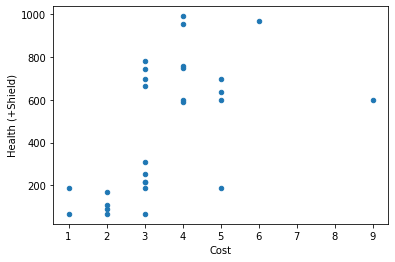

In [115]:
subset=getCleanSubset(data,["Health (+Shield)","Cost"])
subset.plot.scatter(x="Cost",y="Health (+Shield)")
print("Correlation:",subset["Cost"].corr(subset["Health (+Shield)"]))

###Exercise: Do the same with some other values

Add a new code cell below this text, copy-paste the code above to it, and edit it. Which values are highly correlated with the cost?

####Solution (expand to show code)

Correlation: 0.3795885518967999


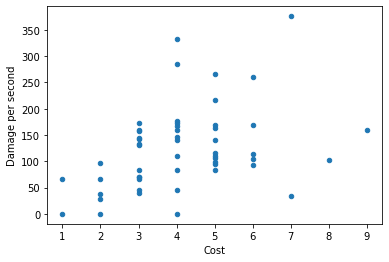

In [130]:
subset=getCleanSubset(data,["Damage per second","Cost"])
subset.plot.scatter(x="Cost",y="Damage per second")
print("Correlation:",subset["Cost"].corr(subset["Damage per second"]))

###Calculating benefit based on multiple values
The code below shows how to perform math on Pandas dataframe columns and add the results as a new column. We call this column "Benefit" and calculate it as the sum of damage per second and health. This yields a tiny bit better correlation (to be improved in the exercise that follows).

Correlation: 0.5556838560806563


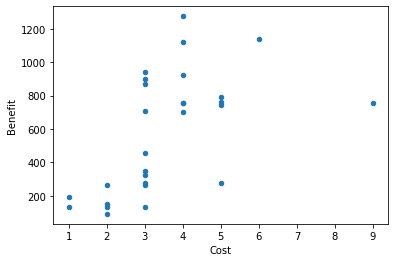

In [129]:
#Example of adding a new column that combines existing ones
s=getCleanSubset(data,["Damage per second","Health (+Shield)","Cost"])
s["Benefit"]=s["Damage per second"]+s["Health (+Shield)"]
s.plot.scatter(x="Cost",y="Benefit")
print("Correlation:",s["Cost"].corr(s["Benefit"]))

###Exercise: Improve the benefit calculation
Improve the code above by figuring out how to combine at least three stats. 

How close to 1 can you get the correlation? If you can get a correlation of 1, you have reverse-engineered how Clash Royale designers balance the stats.


####Hint: (expand this section to show)


Try using "Damage per second", "Count", and "Health (+Shield)". Note that you can use all basic math operations such as multiplication and addition. Consider that the total damage caused by a troop depends on both damage per second and the troop's lifespan, and the lifespan depends on health.

####Solution: (expand this section to show)

In this example solution (which is not the only possible one), we multiply the DPS, count, and health together. This way, the benefit is calculated as the total damage the a troop (or a swarm of "Count" units) might deal to an opponent. 

Of course, this is still a simple approximation, omitting details like a swarm being weak against splash damage.

Correlation: 0.7285591563261166


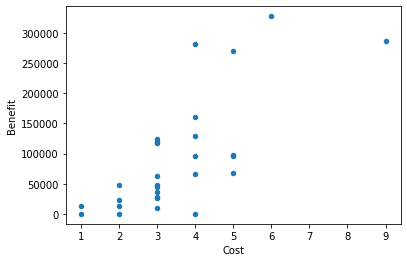

In [128]:
s=getCleanSubset(data,["Damage per second","Count","Health (+Shield)","Cost"])
s["Benefit"]=s["Count"]*s["Damage per second"]*s["Health (+Shield)"]
s.plot.scatter(x="Cost",y="Benefit")
print("Correlation:",s["Cost"].corr(s["Benefit"]))

###Advanced exercise: 
Extend the benefit calculation to all card types. You may need to loop over all cards in a for loop and do the benefit calculation differently for each type. Also try to incorporate mechanics like death damage and ranged attacks.

How close to 1 can you get the correlation?

###Advanced exercise:
The dataset we use is old and does not include all the cards of the current Clash Royale version. Write Python code the scrapes the current stats from a website like https://clashroyale.fandom.com/wiki/Cards 

